In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Kara = pd.read_excel(filepath, sheet_name='Kara-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Kara)
fp.date_time(Kara)

,Extent,Date
0,917992.880,1979-01-01
1,917992.880,1979-02-01
2,917992.880,1979-03-01
3,917992.880,1979-04-01
4,917992.880,1979-05-01
...,...,...
533,728642.743,2023-06-01
534,437024.646,2023-07-01
535,202260.789,2023-08-01
536,98103.856,2023-09-01


In [5]:
scaler = MinMaxScaler()
Kara['Extent'] = scaler.fit_transform(Kara['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 2
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Kara['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((525, 12, 1), (525,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Kara_model_LT2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 14s 173ms/step - loss: 0.5969 - root_mean_squared_error: 0.7726 - val_loss: 0.4015 - val_root_mean_squared_error: 0.6336
Epoch 2/50
53/53 [==============================] - 7s 131ms/step - loss: 0.2233 - root_mean_squared_error: 0.4726 - val_loss: 0.1125 - val_root_mean_squared_error: 0.3354
Epoch 3/50
53/53 [==============================] - 6s 121ms/step - loss: 0.0660 - root_mean_squared_error: 0.2568 - val_loss: 0.1041 - val_root_mean_squared_error: 0.3227
Epoch 4/50
53/53 [==============================] - 7s 131ms/step - loss: 0.0642 - root_mean_squared_error: 0.2533 - val_loss: 0.0934 - val_root_mean_squared_error: 0.3056
Epoch 5/50
53/53 [==============================] - 7s 128ms/step - loss: 0.0551 - root_mean_squared_error: 0.2348 - val_loss: 0.0803 - val_root_mean_squared_error: 0.2833
Epoch 6/50
53/53 [==============================] - 6s 119ms/step - loss: 0.0450 - root_mean_squared_error: 0.2121 - val_loss: 0.0683 - val

Epoch 29/50
53/53 [==============================] - 10s 194ms/step - loss: 0.0227 - root_mean_squared_error: 0.1506 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1639
Epoch 30/50
53/53 [==============================] - 10s 201ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1623
Epoch 31/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0217 - root_mean_squared_error: 0.1474 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1652
Epoch 32/50
53/53 [==============================] - 2s 35ms/step - loss: 0.0231 - root_mean_squared_error: 0.1521 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1775
Epoch 33/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0220 - root_mean_squared_error: 0.1482 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1631
Epoch 34/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0231 - root_mean_squared_error: 0.1520 - val_loss: 0.0253 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.7779885331789655 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

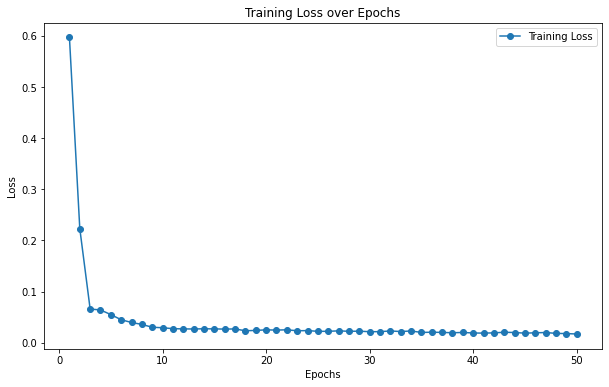

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

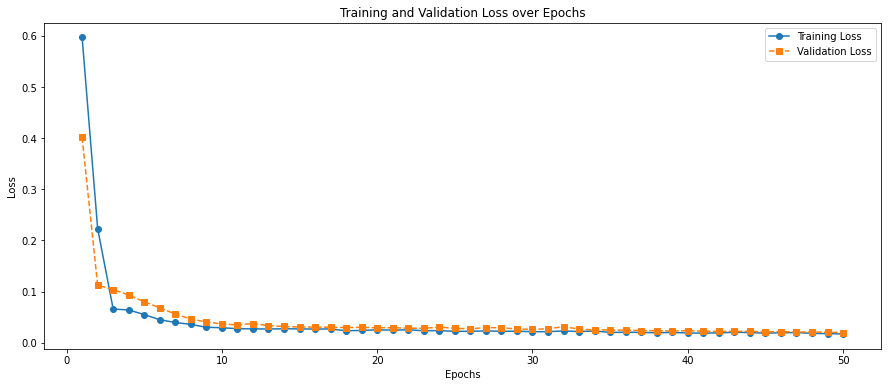

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Kara_model_LT2/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 15ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.14851824163818803
MAE : 0.11144591930112875


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,830568.750000,763496.585
1,462001.750000,282691.615
2,178677.828125,71897.386
3,190729.515625,60592.380
4,291881.281250,131973.043
5,457847.406250,753595.099
6,715205.687500,909176.475
7,824207.250000,917006.278
8,875882.125000,906368.363
9,893446.687500,917403.622


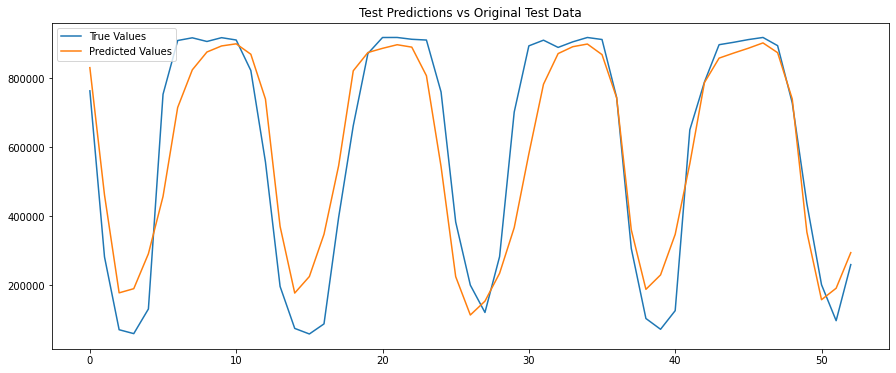

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 15ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

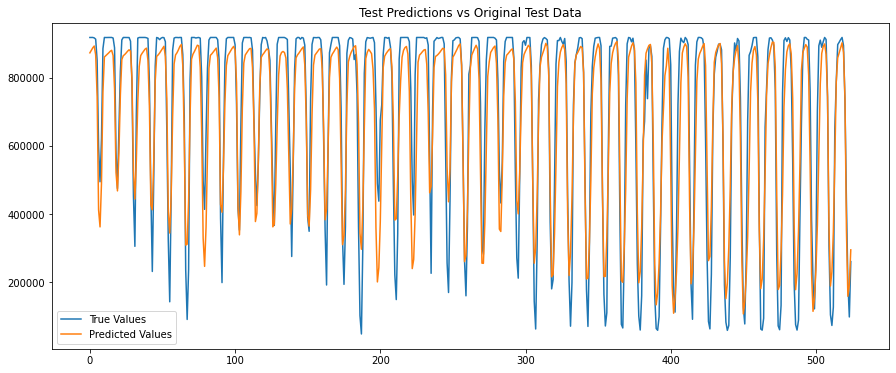

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()